In [12]:
import numpy as np
import pandas as pd
import scipy
from numpy.random import default_rng

rng = default_rng(seed=1)
from sklearn.utils import resample
import matplotlib.pyplot as plt
from scipy.stats import ksone

gridspec_kw = {
    "hspace": 0.00,
    "wspace": 0.00,
    "left": 0.05,
    "right": 0.98,
    "bottom": 0.06,
    "top": 0.98,
}


def plot_p(p, p2=None, ax=None, figsize=(5, 2.5)):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, gridspec_kw=gridspec_kw)
    ax.plot(p["t"], p["v"], "D", markersize=3, mfc="black", mec="black")
    ax.errorbar(p["t"], p["v"], yerr=p["sigma"], fmt="none", ecolor="black", capsize=0)
    if p2 is not None:
        ax.plot(p2["t"], p2["v"], "D", markersize=3, mfc="blue", mec="blue")
        ax.errorbar(p2["t"], p2["v"], yerr=p2["sigma"], fmt="none", ecolor="blue", capsize=0)
    # ax.set_ylim(-3, 12)
    ax.set_xlabel("Time $[$s$]$")
    ax.set_ylabel("Load $[$W$]$")
    ax.grid(
        **{
            "color": "#4f8c9d",
            "alpha": 0.8,
            "linestyle": ":",
            "linewidth": 0.5,
        }
    )
    ax.tick_params(
        direction="in",
        which="both",
        right=True,
        top=True,
        labelsize="x-large",
    )
    # ax.set(**gridspec_kw)


# plot results of check_unary_point_wise as a function of time

def plot_check_unary_point_wise(p, values, ax=None, figsize=(5, 2.5), xlabel=""):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, gridspec_kw=gridspec_kw)
    ax.plot(p["t"], values, "D", markersize=3, mfc="black", mec="black")
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel("Time $[$s$]$")
    ax.set_ylabel(xlabel)
    ax.grid(
        **{
            "color": "#4f8c9d",
            "alpha": 0.8,
            "linestyle": ":",
            "linewidth": 0.5,
        }
    )
    ax.tick_params(
        direction="in",
        which="both",
        right=True,
        top=True,
        labelsize="x-large",
    )
    # ax.set(**gridspec_kw)

    # for alpha, confidence_interval in [ (0.3, posterior.interval(0.99)),(0.2, posterior.interval(0.95)), (0.1, posterior.interval(0.9)), (0.05, posterior.interval(0.8))]:
    #     ax.fill_between(p["t"], confidence_interval[0], confidence_interval[1], alpha=alpha, color='grey')


def plot_posterior_unary(p, posterior, ax=None, figsize=(5, 2.5), xlabel=""):
    # get expected value of posterior distribution
    expected_value = posterior.mean()

    # get confidence interval of posterior distribution
    confidence_interval = posterior.interval(0.95)

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, gridspec_kw=gridspec_kw)
    ax.plot(p["t"], expected_value, "D", markersize=3, mfc="black", mec="black")
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel("Time $[$s$]$")
    ax.set_ylabel(xlabel)
    ax.grid(
        **{
            "color": "#4f8c9d",
            "alpha": 0.8,
            "linestyle": ":",
            "linewidth": 0.5,
        }
    )
    ax.tick_params(
        direction="in",
        which="both",
        right=True,
        top=True,
        labelsize="x-large",
    )
    # ax.set(**gridspec_kw)

    for alpha, confidence_interval in [
        (0.05, posterior.interval(0.8)),
        (0.1, posterior.interval(0.9)),
        (0.15, posterior.interval(0.95)),
        (0.2, posterior.interval(0.99)),
    ]:
        ax.fill_between(p["t"], confidence_interval[0], confidence_interval[1], alpha=alpha, color='grey')


def check_point_wise(fn_test, x_v, x_sigma, y_v=None, y_sigma=None, n_samples=100):
    """apply a function to every element in the series using bootstrap_single and return an array of the ratio of successes"""
    if x_v is not None and x_sigma is None or x_v is None and x_sigma is not None:
        raise ValueError("x_v and x_sigma must be both None or both provided.")

    if not len(x_v) == len(x_sigma):
        raise ValueError("x_v, x_sigmamust be of same length.")

    if y_v is not None and not (len(x_v) == len(y_v) == len(y_sigma)):
        raise ValueError("x_v, x_sigma, y_v, y_sigma must be of same length.")

    results = np.zeros(len(x_v))

    # create samples of x by repeating original values and adding gaussian noise with std=eps
    x_samples = np.zeros((n_samples, len(x_v)))
    if y_v is not None:
        y_samples = np.zeros((n_samples, len(y_v)))

    for i in range(n_samples):
        x_samples[i] = x_v + np.random.normal(0, x_sigma, len(x_v))
        if y_v is not None:
            y_samples[i] = y_v + np.random.normal(0, y_sigma, len(y_v))

    # apply fn_test to every element in x_samples and store count of trues in results
    for i in range(len(x_v)):
        if y_v is None:  # unary constraint
            results[i] = np.sum(fn_test(x_samples[:, i]))
        else:  # binary constraint
            results[i] = np.sum(fn_test(x_samples[:, i], y_samples[:, i]))

    prior_successes = 1
    prior_failures = 1
    observed_successes = results
    n_observations = n_samples

    # get posterior distribution from bayesian binominal test (beta distribution)
    posterior = scipy.stats.beta(prior_successes + observed_successes,
                                 prior_failures + n_observations - observed_successes)

    return posterior

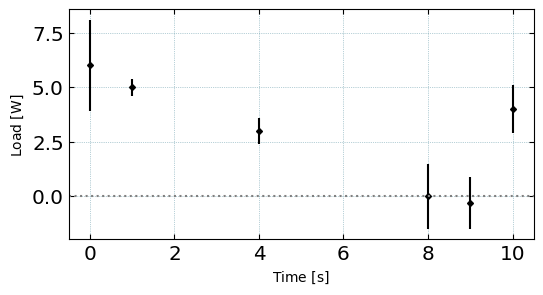

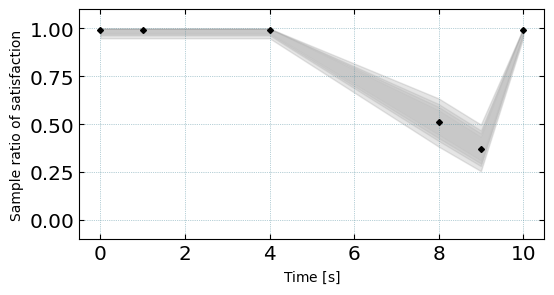

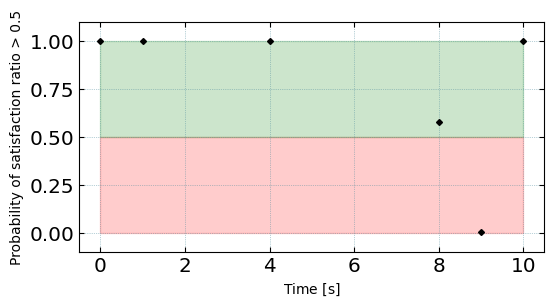

In [13]:
# example with something being larger than zero

p_zero = pd.DataFrame({"t": [0, 1, 4, 8, 9, 10],
                       "v": [6, 5, 3, 0, -0.3, 4],
                       "sigma": [2.1, 0.4, 0.6, 1.5, 1.2, 1.1],
                       })

plot_p(p_zero)
plt.axhline(0, color='grey', linestyle=':')

# point-wise unary constraint that p_zero is larger than zero
posterior = check_point_wise(lambda x: x > 0, p_zero.v, p_zero.sigma, n_samples=100)

# get probability of posterior distribution being larger than 0.5
prob_satisfied = 1 - posterior.cdf(0.5)

plot_posterior_unary(p_zero, posterior, xlabel="Sample ratio of satisfaction")
# plt.fill_between(p_zero["t"], 0, 0.5, alpha=0.2, color='red')
# plt.fill_between(p_zero["t"], 0.5, 1, alpha=0.2, color='green')
plot_check_unary_point_wise(p_zero, prob_satisfied, xlabel="Probability of satisfaction ratio > 0.5")
plt.fill_between(p_zero["t"], 0, 0.5, alpha=0.2, color='red')
plt.fill_between(p_zero["t"], 0.5, 1, alpha=0.2, color='green')

# fill like this but for the entire plot x_range: plt.fill_between(p_zero["t"], 0, 0.5, alpha=0.2, color='red')


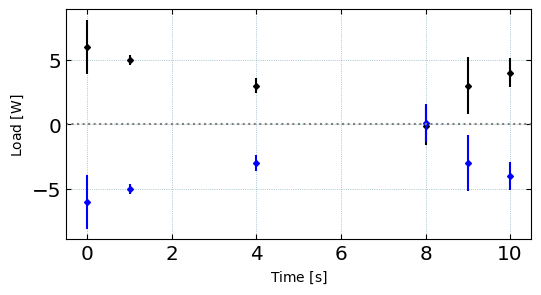

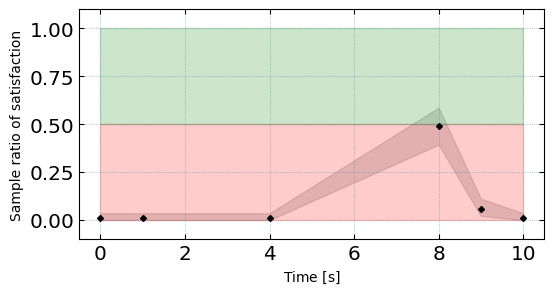

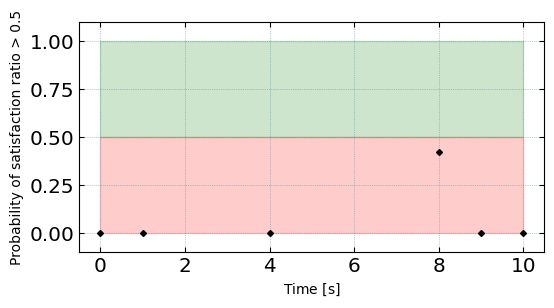

In [175]:
# example with something being larger than zero

p_zero = pd.DataFrame({"t": [0, 1, 4, 8, 9, 10],
                       "v": [6, 5, 3, -0.1, 3, 4],
                       "sigma": [2.1, 0.4, 0.6, 1.5, 2.2, 1.1],
                       })

p_two = p_zero.assign(v=np.array([6, 5, 3, -0.1, 3, 4]) * -1)

plot_p(p_zero, p_two)
plt.axhline(0, color='grey', linestyle=':')

# point-wise unary constraint that p_zero is larger than zero
check = lambda x, y: (y - x) > 0
expected_value, confidence_interval, prob_satisfied = check_point_wise(check, p_zero.v, p_zero.sigma, p_two.v,
                                                                       p_two.sigma, n_samples=100)

plot_check_unary_point_wise(p_zero, expected_value, confidence_interval, xlabel="Sample ratio of satisfaction")
plt.fill_between(p_zero["t"], 0, 0.5, alpha=0.2, color='red')
plt.fill_between(p_zero["t"], 0.5, 1, alpha=0.2, color='green')
plot_check_unary_point_wise(p_zero, prob_satisfied, xlabel="Probability of satisfaction ratio > 0.5")
# plt.axhline(0.5, color='grey', linestyle=':')
plt.fill_between(p_zero["t"], 0, 0.5, alpha=0.2, color='red')
plt.fill_between(p_zero["t"], 0.5, 1, alpha=0.2, color='green')

(array([0.94606765, 0.96413538, 0.96413538, 0.24562117, 0.86240412,
        0.96413538]),
 array([0.99759283, 0.99974936, 0.99974936, 0.42723683, 0.96518309,
        0.99974936]))

In [3]:
# use median distance between data points as bin width , show confidence interval instead of just expected value, when there is no data have completely wide confidence interval

In [7]:
from scipy import stats
import numpy as np

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


@interact
def beta_plot(a=5, b=10):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    beta = lambda x, a, b: stats.beta.pdf(x, a, b)
    axs[0].plot(np.linspace(0, 1, 100), beta(np.linspace(0, 1, 100), a, b))
    axs[0].set_xlabel(f'f({a},{b})')
    axs[0].set_ylabel('density')
    axs[1].plot(np.linspace(0, 1, 100), beta(np.linspace(0, 1, 100), 1.005, 1.005))
    axs[1].set_xlabel('f(1,1)')
    axs[1].set_ylabel('density')



interactive(children=(IntSlider(value=5, description='a', max=15, min=-5), IntSlider(value=10, description='b'…

In [103]:
def check_windowed_unary(check, x, window_spec):
    """ x is a pandas dataframe with columns t, l, l_u,
        check is a function that takes a dataframe like x and returns a boolean
        window is an iterator of dataframes like x
    """
    # first smear dataframe by uncertainty
    # then apply check in rolling window
    results = x.v.rolling(**window_spec).apply(lambda x: check(x), raw=True)
    print(results)


print(p_zero)


def check(x):
    return (x[1] - x[0]) <= 2


# fixed number of observations : window
# fixed size of interval: window_size
check_windowed_unary(check, p_zero, {"window": 3})


    t    v  sigma
0   0  6.0    2.1
1   1  5.0    0.4
2   4  3.0    0.6
3   8 -0.1    1.5
4   9  3.0    2.2
5  10  4.0    1.1
0    NaN
1    NaN
2    1.0
3    1.0
4    1.0
5    0.0
Name: v, dtype: float64


In [110]:

pd.to_datetime([0, 1, 4, 8, 9, 10], unit="D")

DatetimeIndex(['1970-01-01', '1970-01-02', '1970-01-05', '1970-01-09',
               '1970-01-10', '1970-01-11'],
              dtype='datetime64[ns]', freq=None)

,t,l,l_u
0,0,6.0,2.1
1,1,5.0,0.4
2,4,3.0,0.6
3,8,-0.1,1.5
4,9,3.0,2.2
5,10,4.0,1.1


In [87]:
p_zero

,t,l,l_u
0,0,6.0,2.1
1,1,5.0,0.4
2,4,3.0,0.6
3,8,-0.1,1.5
4,9,3.0,2.2
5,10,4.0,1.1
